# Project Description

This project is part of a Kaggle competition, which can be found at:https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

The goal of the project is to predict the target variable 'SalePrice' of residential homes in Ames, Iowa.

The dataset includes 79 explanatory variables that capture almost every aspect of the homes, from basic features like the number of bedrooms to more complex ones like the proximity to an east-west railroad. For detailed information about the features, please refer to the 'data_description' file.


# Installing and importing Libraries

First of all we have to install and import necessary libraries to continuoue.

In [ ]:
pip install catboost

In [2]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score , make_scorer , mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import  RandomForestRegressor , GradientBoostingRegressor , VotingRegressor , StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant



# Remove Warnings
import warnings
warnings.filterwarnings('ignore')

# Data Aggregation and Integration

To increase the size of our training set, we will add the [Ames Housing Dataset](https://www.kaggle.com/datasets/shashanknecrothapa/ames-housing-dataset) to our training data. We'll name this dataset df_ext since our goal is to extend our data using it.

In [3]:
#Reading the Data
df = pd.read_csv('/content/train.csv', keep_default_na=False, na_values = ['NA' , ''])
df_test = pd.read_csv('/content/test.csv', keep_default_na=False, na_values = ['NA' , ''])
df_ext = pd.read_csv('/content/AmesHousing.csv', keep_default_na=False, na_values = ['NA' , ''])

There are some differences in feature names between the two datasets. For example, the Ames Housing Dataset includes spaces in feature names. The column PID is redundant, so we will remove it. Additionally, we need to replace Order with Id and change the feature YearRemod/Add to YearRemodAdd to ensure consistent feature names across both datasets.

In [4]:
# Removing spaces in feature names
cols = df_ext.columns
cols2 = []
for col in cols:
    cols2.append(col.replace(' ',''))

#removing redundant columns and renaming features to ensure consistent variable names across the datasets.
df_ext.columns = cols2
df_ext.drop(columns = ['PID'], inplace=True)
df_ext = df_ext.rename(columns = {'Order':'Id', 'YearRemod/Add':'YearRemodAdd'})

Although we've made variable names consistent with the original data, some non-numeric feature values may still differ from those in the original dataset. We need to ensure consistency in categorical values, just as we did with feature names.


To do this, we will create two DataFrames to hold the unique values of each categorical feature. One of these DataFrames, called df_categorical, will contain the original data values, while df_ext_categorical will store the unique values from the Ames Housing Dataset.

In [5]:
categorical_1 = df.select_dtypes(include = ['object']).columns.tolist()
categorical_2 = df_ext.select_dtypes(include =  ['object']).columns.tolist()

#Creating a list that stores dictionaries, each containing the unique values of a feature along with the feature name (Original Dataset).
categorical_values_1 = []

#Calculating the unique values for each categorical feature and adding them to the list in the form of a dictionary.
for i in categorical_1:
    unique_values = df[i].unique()
    categorical_values_1.append({'Feature': i, 'Unique Values': unique_values})

#Converting the list of dictionaries into a DataFrame.
df_categorical = pd.DataFrame(categorical_values_1)


#Creating a list that stores dictionaries, each containing the unique values of a feature along with the feature name (Added Dataset).
categorical_values_2 = []

#Calculating the unique values for each categorical feature and adding them to the list in the form of a dictionary.
for i in categorical_2:
    unique_values = df_ext[i].unique()
    categorical_values_2.append({'Feature': i, 'Unique Values': unique_values})

#Converting the list of dictionaries into a DataFrame.
df_ex_categorical = pd.DataFrame(categorical_values_2)


Now, we want to compare the two DataFrames containing unique values for both datasets to identify which features have differing values.

For this purpose, we will place the unique values for each dataset into a set, allowing us to compare them and determine whether the features differ or not. If they are different, we will add the feature name to the different_features list.

In [6]:
# identifying features with different unique values.

# Creating a list to store feature names with differing unique values.
different_features = []

# Checking the uniqueness of values for each feature to ensure they are the same.
for feature in df_categorical['Feature']:
    unique_values_1 = set(df_categorical.loc[df_categorical['Feature'] == feature, 'Unique Values'].values[0])
    unique_values_2 = set(df_ex_categorical.loc[df_ex_categorical['Feature'] == feature, 'Unique Values'].values[0])

#Comparing the sets.
    if unique_values_1 != unique_values_2:
        different_features.append(feature)

#Printing the results
print("Features with different unique values:", different_features)

Features with different unique values: ['MSZoning', 'Utilities', 'Neighborhood', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'KitchenQual', 'Functional', 'PoolQC', 'MiscFeature', 'SaleType']


Once again, we calculate the unique values, but this time we focus only on those features that have differing values compared to the original feature values.

In [7]:
df_diff_values = []
for i in different_features:
    unique_values = df[i].unique()
    df_diff_values.append({'Feature': i, 'Unique Values': unique_values})


df_ex_diff_values = []
for i in different_features:
    unique_values = df_ext[i].unique()
    df_ex_diff_values.append({'Feature': i, 'Unique Values': unique_values})

Now that we have the feature names with differing values from the original data, as well as their respective values, we can identify which values exist in the original data but not in the added data. Similarly, we can find which values are present in the added data but absent from the original dataset.

In [8]:
# dictionary to store the differences.
difference_dict = {}

for i in range(len(df_diff_values)):
    feature_name = df_diff_values[i]['Feature']

    # The unique values of each feature in both DataFrames.
    values_1 = set(df_diff_values[i]['Unique Values'])
    values_2 = set(df_ex_diff_values[i]['Unique Values'])

    # Calculating the differences.
    not_in_ext = list(values_1 - values_2)  # Values that are present in the original DataFrame but not in the second DataFrame.
    not_in_orig = list(values_2 - values_1)  # Values that are present in the second DataFrame but not in the original DataFrame.

    # Storing the differences in the dictionary.
    difference_dict[feature_name] = {
        'Not in Extended': not_in_ext,
        'Not in Original': not_in_orig
    }

# Printing Diffrencess
for feature, diff in difference_dict.items():
    print(f"Feature: {feature}")
    print(f"Values in original data but not in extended: {diff['Not in Extended']}")
    print(f"Values in extended data but not in original: {diff['Not in Original']}")
    print("-" * 40)


Feature: MSZoning
Values in original data but not in extended: []
Values in extended data but not in original: ['I (all)', 'A (agr)']
----------------------------------------
Feature: Utilities
Values in original data but not in extended: []
Values in extended data but not in original: ['NoSewr']
----------------------------------------
Feature: Neighborhood
Values in original data but not in extended: []
Values in extended data but not in original: ['Landmrk', 'GrnHill', 'Greens']
----------------------------------------
Feature: Exterior1st
Values in original data but not in extended: []
Values in extended data but not in original: ['PreCast']
----------------------------------------
Feature: Exterior2nd
Values in original data but not in extended: []
Values in extended data but not in original: ['PreCast']
----------------------------------------
Feature: MasVnrType
Values in original data but not in extended: []
Values in extended data but not in original: ['CBlock']
--------------

Looking at the output above, we can see that there are cases where the values differ. For instance, in the case of the "MSZoning" feature, our original DataFrame does not include a value of 'I (all)', so we need to change it to 'I' to match our original DataFrame. Additionally, we should change the value 'A (agr)' to 'A' as well.

Regarding the features "Utilities", "Exterior1st", "Exterior2nd" , "MasVnrType" , "BsmtQual" , "BsmtCond" , "KitchenQual" , "Functional" , "PoolQC" , and "MiscFeature" there's an interesting point to note. If we look at the output from the previous code, we can see that these features have values that do not exist in our original data. However, if we refer to the data description file, we find that these values are valid, but there were no instances in our training data that contained them. Therefore, we will not remove these values, as we are taking into account the information provided in the description file.

Regarding the Neighborhood feature, since we do not have the values 'Greens', 'GrnHill', and 'Landmrk' listed in the description file for this feature, we will remove all data containing these values from our dataset.

Finally, regarding the SaleType feature, we have two different values that require distinct actions. For the value 'VWD', we do not need to take any action, as this value is available in the description file for this feature and is valid; as mentioned before, we do not have any records containing this value in our training data. For the value 'WD', there is a spelling error due to an unnecessary space at the end of 'WD', which we need to remove.



In [9]:
df_ext['MSZoning'].replace('I (all)', 'I', inplace = True)
df_ext['MSZoning'].replace('A (agr)' , 'A' , inplace = True)
df_ext = df_ext[~df_ext['Neighborhood'].isin(['Greens', 'GrnHill', 'Landmrk'])]
df_ext['SaleType'].replace('WD ', 'WD' , inplace = True)


Now that we have consistent feature names and values, we can extend the training data by concatenating the two datasets. To maintain consistent indexing in the Id column, we need to remove the Id column and create a new indexing column from the beginning, renaming it to Id. After removing the Id column, it will also be a good opportunity to eliminate duplicates in our DataFrame, as the Id column would complicate the process of dropping duplicates.

In [10]:
#Concatinating the two Datasets together
df = pd.concat([df, df_ext], ignore_index=True)

# Removing the previous Id column.
df = df.drop(columns=['Id'])

# Droping Duplicates
df.drop_duplicates(inplace = True)

# Re-indexing from the beginning and then renaming the index column to Id, as it was before.
df.index = range(1, len(df) + 1)
df.reset_index(inplace=True)
df.rename(columns={'index': 'Id'}, inplace=True)

# Data Analysis

In [11]:
# Set pandas options to display all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # No limit on display width

In [12]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2919 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2919 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC


Looking at the above output, we can see that our new dataset contains 2,919 entries. Many of these data points have missing values.

In [14]:
#splitting the data into numerical and categorical
numerical = df.select_dtypes(include = ['float64', 'int64']).columns.tolist()
categorical = df.select_dtypes(include = ['object']).columns.tolist()

print('number of numerical features is: ' , len(numerical))
print('number of categorical features is: ' , len(categorical))

number of numerical features is:  38
number of categorical features is:  43


In [15]:
df[numerical].describe().T

,count,mean,std,min,25%,50%,75%,max
Id,2919.0,1460.000000,842.787043,1.0,730.5,1460.0,2189.5,2919.0
MSSubClass,2919.0,57.137718,42.517628,20.0,20.0,50.0,70.0,190.0
LotFrontage,2433.0,69.305795,23.344905,21.0,59.0,68.0,80.0,313.0
LotArea,2919.0,10168.114080,7886.996359,1300.0,7478.0,9453.0,11570.0,215245.0
OverallQual,2919.0,6.089072,1.409947,1.0,5.0,6.0,7.0,10.0
OverallCond,2919.0,5.564577,1.113131,1.0,5.0,5.0,6.0,9.0
YearBuilt,2919.0,1971.312778,30.291442,1872.0,1953.5,1973.0,2001.0,2010.0
YearRemodAdd,2919.0,1984.264474,20.894344,1950.0,1965.0,1993.0,2004.0,2010.0
MasVnrArea,2896.0,102.201312,179.334253,0.0,0.0,0.0,164.0,1600.0
BsmtFinSF1,2918.0,441.423235,455.610826,0.0,0.0,368.5,733.0,5644.0


In [16]:
df.describe(include = 'object').T

,count,unique,top,freq
MSZoning,2919,7,RL,2265
Street,2919,2,Pave,2907
Alley,198,2,Grvl,120
LotShape,2919,4,Reg,1859
LandContour,2919,4,Lvl,2622
Utilities,2919,3,AllPub,2916
LotConfig,2919,5,Inside,2133
LandSlope,2919,3,Gtl,2778
Neighborhood,2919,25,NAmes,443
Condition1,2919,9,Norm,2511


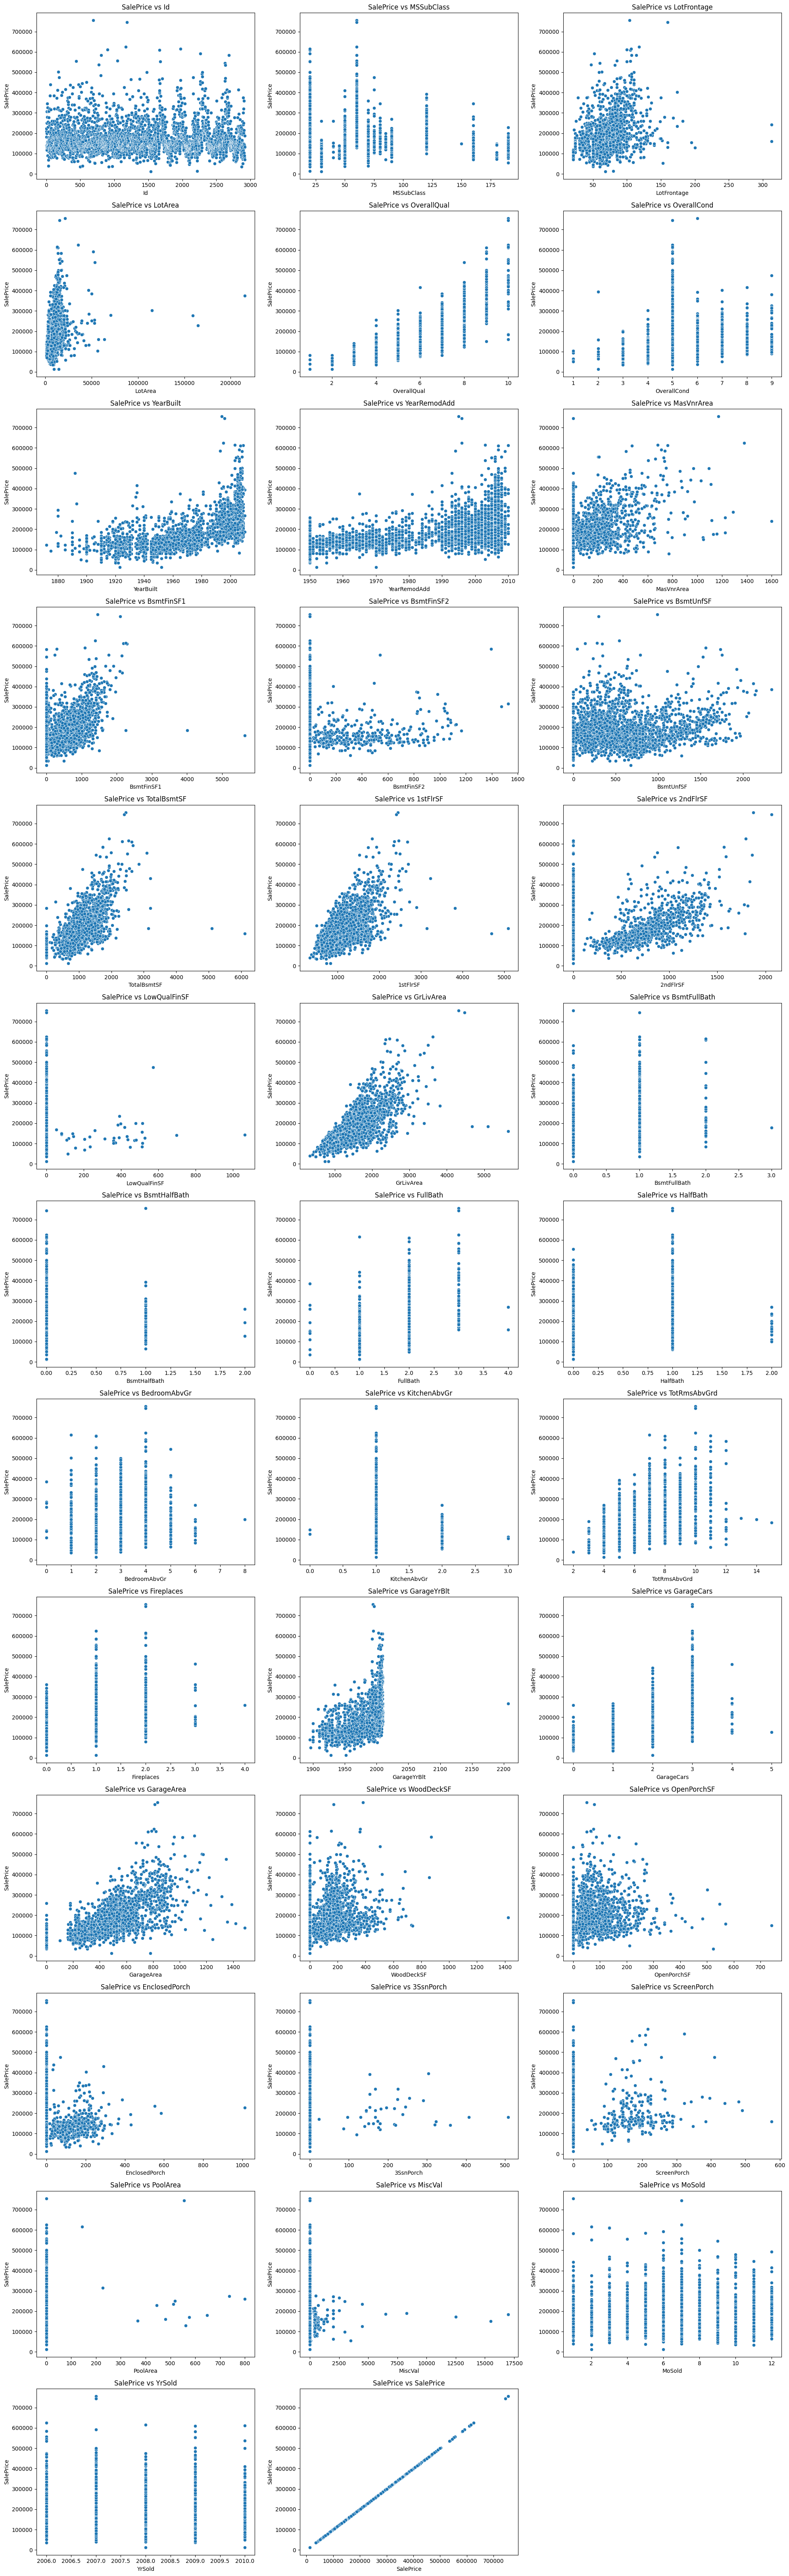

In [17]:
# Plotting a scatter chart of features against the target.
fig, axes = plt.subplots(13, 3, figsize=(20, 5 * 13))
axes = axes.flatten()

for i, feature in enumerate(df[numerical]):
    sns.scatterplot(ax=axes[i], x=df[feature], y=df['SalePrice'])
    axes[i].set_title(f'SalePrice vs {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('SalePrice')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

By looking at the above charts, we can see that certain features contain outliers, which are noticeable even by eye. Next, we will attempt to remove these outliers from our DataFrame.

# Outlier Detection

We remove the outliers that can be visually identified based on scatter plots of features against the target.

In [18]:
# Identifying two data points with the highest SalePrice.

df.sort_values(by = 'SalePrice', ascending = False)[:2]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455.0,Unf,0.0,989.0,2444.0,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0.0,1.0,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3.0,832.0,TA,TA,Y,382,50,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096.0,Unf,0.0,300.0,2396.0,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1.0,0.0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3.0,813.0,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000


In [19]:
# Identifying two data points with the lowest SalePrice.

df.sort_values(by = 'SalePrice', ascending = True)[:2]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1536,1537,30,RM,68.0,9656,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,2,2,1923,1970,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,Fa,BrkTil,Fa,Fa,No,Unf,0.0,Unf,0.0,678.0,678.0,GasA,TA,N,SBrkr,832,0,0,832,0.0,0.0,1,0,2,1,TA,5,Typ,1,Gd,Detchd,1928.0,Unf,2.0,780.0,Fa,Fa,N,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Abnorml,12789
2216,2217,20,A,80.0,14584,Pave,NaN,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.0,Fa,Po,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,Wall,Po,N,FuseA,733,0,0,733,0.0,0.0,1,0,2,1,Fa,4,Sal,0,NaN,Attchd,1952.0,Unf,2.0,487.0,Fa,Po,N,0,0,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Abnorml,13100


In [20]:
# Removing the data points that we identified above. We will remove them using the values from the Id column.

df = df.drop(df[df['Id'] == 692].index)
df = df.drop(df[df['Id'] == 1183].index)
df = df.drop(df[df['Id'] == 1537].index)
df = df.drop(df[df['Id'] == 2217].index)

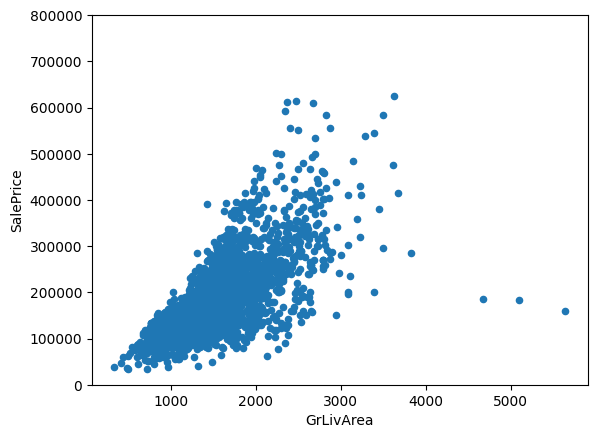

In [21]:
var = 'GrLivArea'
data = pd.concat([df['SalePrice'] , df[var]] , axis =1)
data.plot.scatter(x = var , y ='SalePrice', ylim = (0,800000));

By looking at the 'GrLivArea' diagram, we can identify three different outliers that should be removed.

In [22]:
# Identifying points
df.sort_values(by = 'GrLivArea', ascending = False)[:3]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644.0,Unf,0.0,466.0,6110.0,GasA,Ex,Y,SBrkr,4692,950,0,5642,2.0,0.0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2.0,1418.0,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
2549,2550,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,1224.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,4010.0,Unf,0.0,1085.0,5095.0,GasA,Ex,Y,SBrkr,5095,0,0,5095,1.0,1.0,2,1,2,1,Ex,15,Typ,2,Gd,Attchd,2008.0,Fin,3.0,1154.0,TA,TA,Y,546,484,0,0,0,0,NaN,NaN,Elev,17000,10,2007,New,Partial,183850
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260.0,Unf,0.0,878.0,3138.0,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1.0,0.0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3.0,884.0,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750


In [23]:
# Removing the data points that we identified above. We will remove them using the values from the Id column.

df = df.drop(df[df['Id'] == 1299].index)
df = df.drop(df[df['Id'] == 2550].index)
df = df.drop(df[df['Id'] == 524].index)

We will continue this procedure for other features to remove outliers.


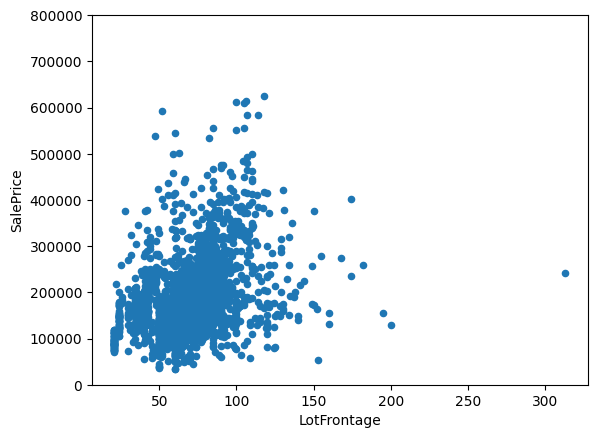

In [24]:
var = 'LotFrontage'
data = pd.concat([df['SalePrice'] , df[var]] , axis =1)
data.plot.scatter(x = var , y ='SalePrice', ylim = (0,800000));

In [25]:
# Identifying points
df.sort_values(by = 'LotFrontage', ascending = False)[:1]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
934,935,20,RL,313.0,27650,Pave,NaN,IR2,HLS,AllPub,Inside,Mod,NAmes,PosA,Norm,1Fam,1Story,7,7,1960,2007,Flat,Tar&Grv,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,Gd,TA,Gd,GLQ,425.0,Unf,0.0,160.0,585.0,GasA,Ex,Y,SBrkr,2069,0,0,2069,1.0,0.0,2,0,4,1,Gd,9,Typ,1,Gd,Attchd,1960.0,RFn,2.0,505.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,11,2008,WD,Normal,242000


In [26]:
# deleting points
df = df.drop(df[df['Id'] == 935].index)

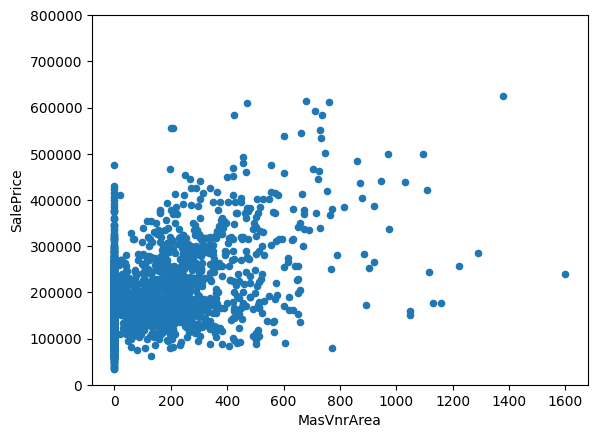

In [27]:
var = 'MasVnrArea'
data = pd.concat([df['SalePrice'] , df[var]] , axis =1)
data.plot.scatter(x = var , y ='SalePrice', ylim = (0,800000));

In [28]:
# Identifying points
df.sort_values(by = 'MasVnrArea', ascending = False)[:1]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
297,298,60,FV,66.0,7399,Pave,Pave,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,5,1997,1998,Hip,CompShg,VinylSd,VinylSd,BrkFace,1600.0,Gd,TA,PConc,Gd,TA,No,BLQ,649.0,Unf,0.0,326.0,975.0,GasA,Ex,Y,SBrkr,975,975,0,1950,0.0,0.0,2,1,3,1,Gd,7,Typ,1,TA,Detchd,1997.0,RFn,2.0,576.0,TA,TA,Y,0,10,0,0,198,0,NaN,NaN,NaN,0,6,2007,WD,Normal,239000


In [29]:
# deleting points
df = df.drop(df[df['Id'] == 298].index)

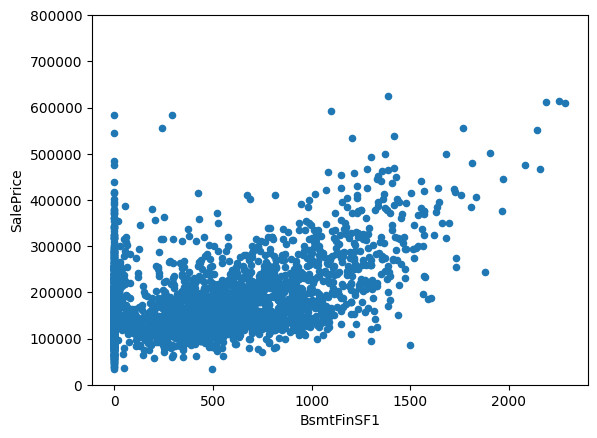

In [30]:
var = 'BsmtFinSF1'
data = pd.concat([df['SalePrice'] , df[var]] , axis =1)
data.plot.scatter(x = var , y ='SalePrice', ylim = (0,800000));

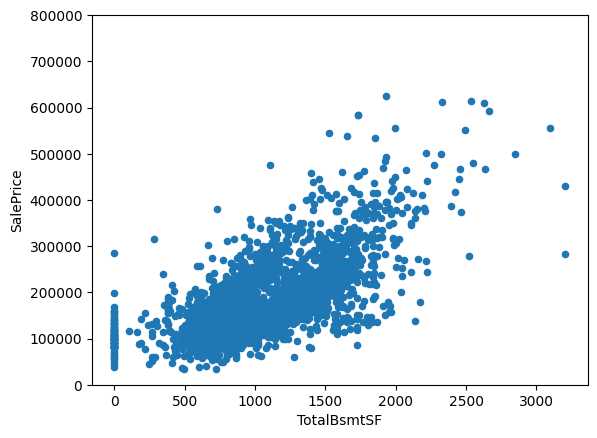

In [31]:
var = 'TotalBsmtSF'
data = pd.concat([df['SalePrice'] , df[var]] , axis =1)
data.plot.scatter(x = var , y ='SalePrice', ylim = (0,800000));

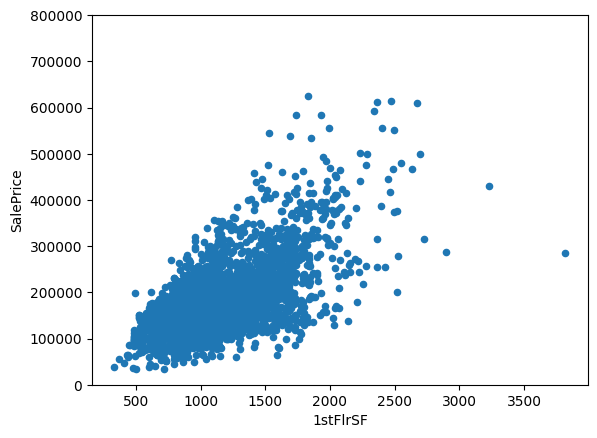

In [32]:
var = '1stFlrSF'
data = pd.concat([df['SalePrice'] , df[var]] , axis =1)
data.plot.scatter(x = var , y ='SalePrice', ylim = (0,800000));

In [33]:
# Identifying points
df.sort_values(by = '1stFlrSF', ascending = False)[:1]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2188,2189,20,RL,123.0,47007,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1959,1996,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,TA,Y,SBrkr,3820,0,0,3820,NaN,NaN,3,1,5,1,Ex,11,Typ,2,Gd,Attchd,1959.0,Unf,2.0,624.0,TA,TA,Y,0,372,0,0,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal,284700


In [34]:
# deleting points
df = df.drop(df[df['Id'] == 2189].index)

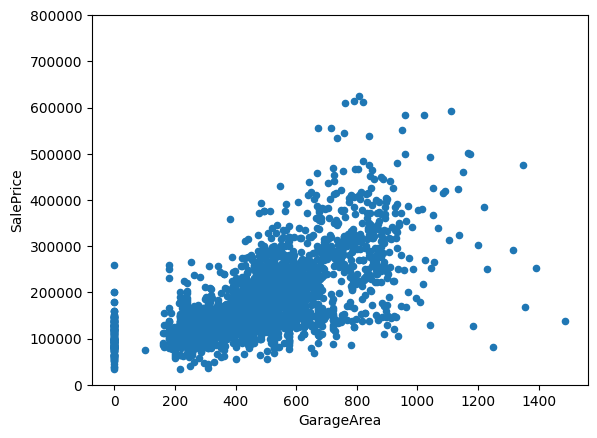

In [35]:
var = 'GarageArea'
data = pd.concat([df['SalePrice'] , df[var]] , axis =1)
data.plot.scatter(x = var , y ='SalePrice', ylim = (0,800000));

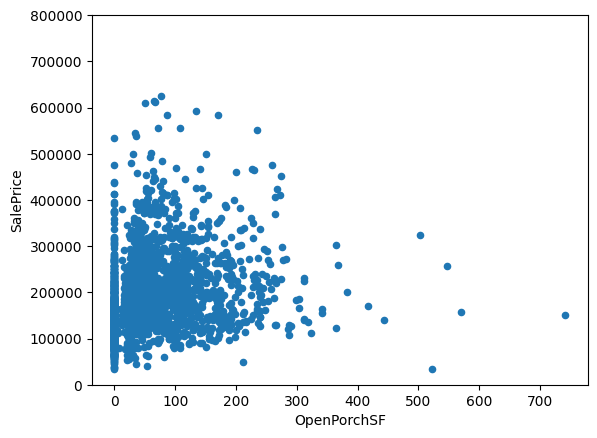

In [36]:
var = 'OpenPorchSF'
data = pd.concat([df['SalePrice'] , df[var]] , axis =1)
data.plot.scatter(x = var , y ='SalePrice', ylim = (0,800000));

In [37]:
# Identifying points
df.sort_values(by = 'OpenPorchSF', ascending = False)[:5]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2557,2558,90,RL,60.0,10890,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SWISU,Norm,Norm,Duplex,2Story,5,6,1923,1950,Hip,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,TA,TA,Mn,Rec,371.0,Unf,0.0,925.0,1296.0,Grav,Fa,N,FuseA,1296,1296,0,2592,2.0,0.0,2,0,6,2,TA,12,Min2,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,742,240,0,0,0,NaN,NaN,Shed,1512,1,2007,WD,AdjLand,150000
2486,2487,60,RL,99.0,16779,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Feedr,Norm,1Fam,2Story,5,4,1920,1996,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,356.0,TA,Fa,CBlock,Gd,TA,No,BLQ,267.0,Unf,0.0,404.0,671.0,GasA,Fa,Y,SBrkr,1567,1087,0,2654,0.0,0.0,3,0,4,1,TA,11,Mod,1,Gd,Attchd,1946.0,Unf,2.0,638.0,TA,TA,Y,128,570,0,0,0,0,NaN,NaN,Shed,500,5,2007,WD,Normal,158000
1328,1329,50,RM,60.0,10440,Pave,Grvl,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,1.5Fin,6,7,1920,1950,Gable,CompShg,BrkFace,Wd Sdng,None,0.0,Gd,Gd,BrkTil,Gd,TA,No,LwQ,493.0,Unf,0.0,1017.0,1510.0,GasW,Ex,Y,SBrkr,1584,1208,0,2792,0.0,0.0,2,0,5,1,TA,8,Mod,2,TA,Detchd,1920.0,Unf,2.0,520.0,Fa,TA,Y,0,547,0,0,480,0,NaN,MnPrv,Shed,1150,6,2008,WD,Normal,256000
495,496,30,C (all),60.0,7879,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,4,5,1920,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,495.0,Unf,0.0,225.0,720.0,GasA,TA,N,FuseA,720,0,0,720,0.0,0.0,1,0,2,1,TA,4,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,N,0,523,115,0,0,0,NaN,GdWo,NaN,0,11,2009,WD,Abnorml,34900
583,584,75,RM,75.0,13500,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,PosA,1Fam,2.5Unf,10,9,1893,2000,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Ex,Ex,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,1237.0,1237.0,GasA,Gd,Y,SBrkr,1521,1254,0,2775,0.0,0.0,3,1,3,1,Gd,9,Typ,1,Gd,Detchd,1988.0,Unf,2.0,880.0,Gd,TA,Y,105,502,0,0,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal,325000


In [38]:
# deleting points
df = df.drop(df[df['Id'] == 2558].index)
df = df.drop(df[df['Id'] == 2487].index)
df = df.drop(df[df['Id'] == 1329].index)
df = df.drop(df[df['Id'] == 496].index)
df = df.drop(df[df['Id'] == 584].index)

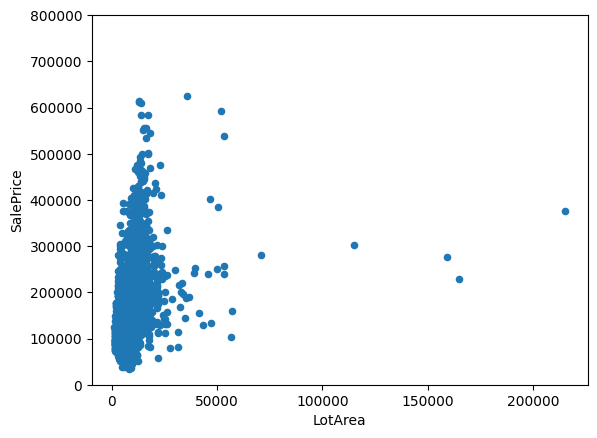

In [39]:
var = 'LotArea'
data = pd.concat([df['SalePrice'] , df[var]] , axis =1)
data.plot.scatter(x = var , y ='SalePrice', ylim = (0,800000));

In [40]:
# Identifying points
df.sort_values(by = 'LotArea', ascending = False)[:4]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
313,314,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,Inside,Sev,Timber,Norm,Norm,1Fam,1Story,7,5,1965,1965,Hip,CompShg,BrkFace,BrkFace,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,1236.0,Rec,820.0,80.0,2136.0,GasW,TA,Y,SBrkr,2036,0,0,2036,2.0,0.0,2,0,3,1,TA,8,Typ,2,Gd,Attchd,1965.0,RFn,2.0,513.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000
335,336,190,RL,NaN,164660,Grvl,NaN,IR1,HLS,AllPub,Corner,Sev,Timber,Norm,Norm,2fmCon,1.5Fin,5,6,1965,1965,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,Gd,ALQ,1249.0,BLQ,147.0,103.0,1499.0,GasA,Ex,Y,SBrkr,1619,167,0,1786,2.0,0.0,2,0,3,1,TA,7,Typ,2,Gd,Attchd,1965.0,Fin,2.0,529.0,TA,TA,Y,670,0,0,0,0,0,NaN,NaN,Shed,700,8,2008,WD,Normal,228950
249,250,50,RL,NaN,159000,Pave,NaN,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1.5Fin,6,7,1958,2006,Gable,CompShg,Wd Sdng,HdBoard,BrkCmn,472.0,Gd,TA,CBlock,Gd,TA,Gd,Rec,697.0,Unf,0.0,747.0,1444.0,GasA,Gd,Y,SBrkr,1444,700,0,2144,0.0,1.0,2,0,4,1,Gd,7,Typ,2,TA,Attchd,1958.0,Fin,2.0,389.0,TA,TA,Y,0,98,0,0,0,0,NaN,NaN,Shed,500,6,2007,WD,Normal,277000
706,707,20,RL,NaN,115149,Pave,NaN,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1Story,7,5,1971,2002,Gable,CompShg,Plywood,Plywood,Stone,351.0,TA,TA,CBlock,Gd,TA,Gd,GLQ,1219.0,Unf,0.0,424.0,1643.0,GasA,TA,Y,SBrkr,1824,0,0,1824,1.0,0.0,2,0,2,1,Gd,5,Typ,2,TA,Attchd,1971.0,Unf,2.0,739.0,TA,TA,Y,380,48,0,0,0,0,NaN,NaN,NaN,0,6,2007,WD,Normal,302000


In [41]:
# deleting points
df = df.drop(df[df['Id'] == 314].index)
df = df.drop(df[df['Id'] == 336].index)
df = df.drop(df[df['Id'] == 250].index)
df = df.drop(df[df['Id'] == 707].index)

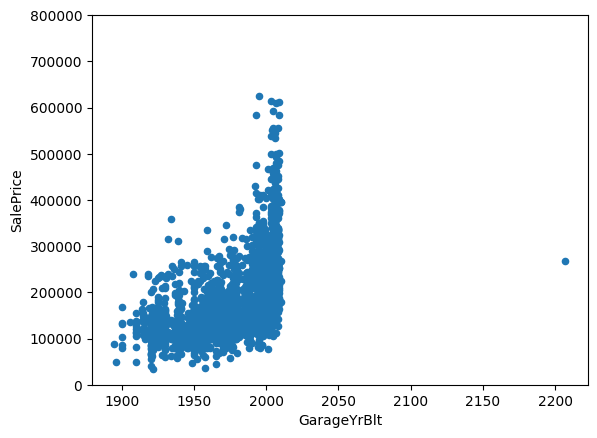

In [42]:
var = 'GarageYrBlt'
data = pd.concat([df['SalePrice'] , df[var]] , axis =1)
data.plot.scatter(x = var , y ='SalePrice', ylim = (0,800000));

In [43]:
# Identifying points
df.sort_values(by = 'GarageYrBlt', ascending = False)[:1]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2592,2593,20,RL,68.0,8298,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2006,2007,Hip,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,Av,GLQ,583.0,Unf,0.0,963.0,1546.0,GasA,Ex,Y,SBrkr,1564,0,0,1564,0.0,0.0,2,0,2,1,Ex,6,Typ,1,Gd,Attchd,2207.0,RFn,2.0,502.0,TA,TA,Y,132,0,0,0,0,0,NaN,NaN,NaN,0,9,2007,New,Partial,267300


In [44]:
# Identifying points
df = df.drop(df[df['Id'] == 2593].index)

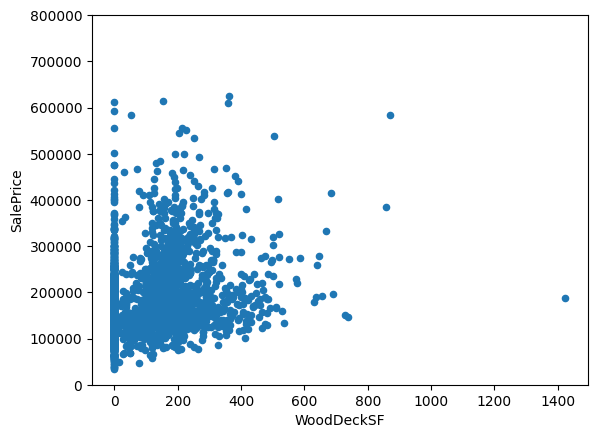

In [45]:
var = 'WoodDeckSF'
data = pd.concat([df['SalePrice'] , df[var]] , axis =1)
data.plot.scatter(x = var , y ='SalePrice', ylim = (0,800000));

In [46]:
# Identifying points
df.sort_values(by = 'WoodDeckSF', ascending = False)[:1]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2606,2607,80,RL,NaN,15957,Pave,NaN,IR1,Low,AllPub,Corner,Mod,Mitchel,Norm,Norm,1Fam,SLvl,6,6,1977,1977,Gable,CompShg,HdBoard,Plywood,None,0.0,TA,TA,PConc,Gd,TA,Gd,GLQ,1148.0,Unf,0.0,96.0,1244.0,GasA,TA,Y,SBrkr,1356,0,0,1356,2.0,0.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1977.0,Fin,2.0,528.0,TA,TA,Y,1424,0,0,0,0,0,NaN,MnPrv,NaN,0,9,2007,WD,Normal,188000


In [47]:
# deleting points
df = df.drop(df[df['Id'] == 2607].index)

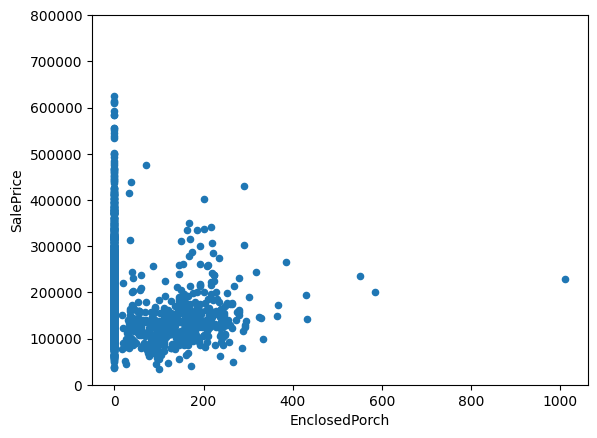

In [48]:
var = 'EnclosedPorch'
data = pd.concat([df['SalePrice'] , df[var]] , axis =1)
data.plot.scatter(x = var , y ='SalePrice', ylim = (0,800000));

In [49]:
# Identifying points
df.sort_values(by = 'EnclosedPorch', ascending = False)[:1]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2503,2504,50,RL,104.0,23920,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Feedr,Norm,1Fam,1.5Fin,6,5,1984,1984,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,1105.0,1105.0,GasA,Ex,Y,SBrkr,1105,717,0,1822,0.0,0.0,2,0,4,1,Gd,7,Min2,1,Po,Attchd,1984.0,Unf,2.0,515.0,TA,TA,P,0,195,1012,0,0,444,TA,NaN,NaN,0,4,2007,WD,Normal,228500


In [50]:
# deleting points
df = df.drop(df[df['Id'] == 2504].index)

# Missing Values , Feature Engineering , and Encoding

We need to remove the Id column so it is not considered a feature during the training stages.

In [51]:
df.drop('Id', axis = 1, inplace = True)
df_test.drop('Id', axis = 1, inplace = True)

In [52]:
# Calculate the ratio of missing data
null_data_ratio = (df.isnull().sum()) * 100 / df.shape[0]
null_data_ratio = null_data_ratio.drop(null_data_ratio[null_data_ratio == 0].index).sort_values(ascending=False)
null_data_ratio

,0
PoolQC,99.654815
MiscFeature,96.548153
Alley,93.234380
Fence,80.428029
FireplaceQu,48.912668
LotFrontage,16.637901
GarageCond,5.419399
GarageQual,5.419399
GarageFinish,5.419399
GarageYrBlt,5.419399


**Missing Values:**
 As mentioned earlier, there are a significant number of missing values that need to be filled using appropriate methods. Interestingly, when we look at the description file, we see that some non-numeric categorical values have a value of Na. The point here is that Pandas considers this Na value as a missing entry by default, whereas we do not want that to be the case.

For example, if the PoolQC feature has a value of Na, it does not indicate a missing value; rather, it means that the specific building does not have a pool. To address this issue, we will convert the Na value to "No" for all categorical features that have Na values (which can be identified by looking at the description file).

In addition to these features, there are features with missing values that should be filled with zero, as well as features where the missing values can be filled with the mode.


In [53]:
def Missing_values(df):
    df['MasVnrType'].fillna(df['MasVnrType'].mode()[0] , inplace = True)
    df['MasVnrArea'].fillna(df['MasVnrArea'].mean(), inplace = True)


    NA_features = ['PoolQC','BsmtQual', 'BsmtCond', 'BsmtExposure', 'FireplaceQu', 'GarageFinish',
                 'GarageQual', 'GarageCond', 'GarageType' , 'Fence', 'Alley', 'BsmtFinType1', 'BsmtFinType2',
                 'MiscFeature']
    for i in NA_features:
        df[i].fillna('No' , inplace = True)

    # Zero imputing missing values:
    missing_features_1 = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF',
                          'BsmtFullBath', 'BsmtHalfBath','GarageArea', 'GarageCars']
    for col in missing_features_1:
        df[col] = df[col].fillna(0)

    # imputing with mode:
    missing_features_2 = ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd',
                         'SaleType', 'Utilities']
    for col in missing_features_2:
        df[col] = df[col].fillna(df[col].mode()[0])

    # Regarding the LotFrontage feature, the best approach is to use the mode values to fill in the missing data for different categories of the Neighborhood.
    # LotFrontage:
    df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(
       lambda x: x.fillna(x.median()))

    # Functional :
    df['Functional'] = df['Functional'].fillna('Typ')

    return df


**Feature Engineering:** We can create more impactful features by combining existing ones. After that, we should remove the original features.

In [54]:
def Feature_engineering(df):
    df['Age_of_property'] = (df['YrSold'] - df['YearBuilt']) *12 + df['MoSold']
    df['Age_of_remodel'] = (df['YrSold'] - df['YearRemodAdd']) * 12 + df['MoSold']
    df['Age_of_garage'] = (df['YrSold'] - df['GarageYrBlt']) * 12 + df['MoSold']
    df['Age_of_garage'].fillna(0 , inplace = True)
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['TotalBathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) +
                             df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))
    df['TotalPorchSF'] = df['WoodDeckSF'] + df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']

    items_to_drop = ['YrSold' , 'YearBuilt' , 'MoSold' ,  'YearRemodAdd' , 'GarageYrBlt' ,  'TotalBsmtSF'
                   , '1stFlrSF' , '2ndFlrSF' ,  'FullBath' , 'HalfBath' , 'BsmtFullBath' , 'BsmtHalfBath' , 'WoodDeckSF' , 'OpenPorchSF'
                     , 'EnclosedPorch' , '3SsnPorch' , 'ScreenPorch']
    df.drop(items_to_drop , axis = 1 , inplace =True)

    return df

**Categorical to numerical encoding:** (Ordinal Features only)
We have two types of categorical data: an ordinal category where the order matters, which will be processed using the OrdinalEncoder, and a nominal category that will use OneHotEncoding. For reasons that will be explained later, we will not include the code for converting nominal data in the following function and will execute it separately. (A brief note: for the training data, we want drop_first = True for the nominal features, but we do not want this option to remain true for the test data due to reasons that will be discussed later.)

In [55]:
def cat_to_num(df):

    ordinal_features = ['LotShape' , 'LandContour' , 'LandSlope' , 'ExterQual' , 'ExterCond' , 'BsmtQual', 'BsmtCond' , 'BsmtExposure', 'BsmtFinType1' , 'BsmtFinType2' , 'HeatingQC',
                        'Electrical' , 'KitchenQual' , 'FireplaceQu' , 'GarageFinish' , 'GarageQual' , 'GarageCond', 'PavedDrive' , 'PoolQC' , 'Fence' , 'CentralAir']

    ordinal_categories = [
            ['IR3' , 'IR2' , 'IR1' , 'Reg'] #LotShape categories
            ,['Low' , 'HLS' , 'Bnk' , 'Lvl'] #LandContour categories
            ,['Sev' , 'Mod' , 'Gtl'] #LandSlope categories
            ,['Po' , 'Fa' , 'TA' , 'Gd' , 'Ex'] #ExterQual categories
            ,['Po' , 'Fa' , 'TA' , 'Gd' , 'Ex'] #ExterCond categories
            ,['No' , 'Po' , 'Fa' , 'TA' , 'Gd' , 'Ex'] #BsmtQual categories
            ,['No' , 'Po' , 'Fa' , 'TA' , 'Gd' , 'Ex'] #BsmtCond categories
            ,['No' , 'Mn' , 'Av' , 'Gd'] #BsmtExposure categories
            ,['No' , 'Unf' , 'LwQ' , 'Rec' , 'BLQ' , 'ALQ' , 'GLQ'] #BsmtFinType1 categories
            ,['No' , 'Unf' , 'LwQ' , 'Rec' , 'BLQ' , 'ALQ' , 'GLQ'] #BsmtFinType2 categories
            ,['Po' , 'Fa' , 'TA' , 'Gd' , 'Ex'] #HeatingQC categories
            ,['Mix' , 'FuseP' , 'FuseF' , 'FuseA' , 'SBrkr'] #Electrical categories
            ,['Po' , 'Fa' , 'TA' , 'Gd' , 'Ex'] #KitchenQual categories
            ,['No' , 'Po' , 'Fa' , 'TA' , 'Gd' , 'Ex'] #FireplaceQu categories
            ,['No' , 'Unf' , 'RFn' , 'Fin'] #GarageFinish categories
            ,['No' , 'Po' , 'Fa' , 'TA' , 'Gd' , 'Ex'] #GarageQual categories
            ,['No' , 'Po' , 'Fa' , 'TA' , 'Gd' , 'Ex'] #GarageCond categories
            ,['N' , 'P' , 'Y'] #PavedDrive categories
            ,['No' , 'Fa' , 'TA' , 'Gd' , 'Ex'] #PoolQC categories
            ,['No' , 'MnWw' , 'GdWo' , 'MnPrv' , 'GdPrv'] #Fence categories
            ,['N' , 'Y'] #CentralAir categories
            ]
    encoder = OrdinalEncoder(categories = ordinal_categories)
    df[ordinal_features] = encoder.fit_transform(df[ordinal_features])

    return df

In [56]:
def transformer(df):

    mv = Missing_values(df)

    Fe = Feature_engineering(mv)

    df = cat_to_num(Fe)

    return df

In [57]:
df = transformer(df)


As previously mentioned, we use get_dummies for nominal features because we want to utilize drop_first = True. This option may behave differently in the training and test datasets, resulting in different variables in the two DataFrames. To address this issue, we will use drop_first = True during training, while disabling this option for testing. Then, we will select all features in the test data that are present in the training data.

In [58]:

df['MSSubClass'] = df['MSSubClass'].apply(str)
nominal_features = ['MSSubClass' , 'MSZoning' , 'Street' , 'Alley' , 'Utilities' , 'LotConfig' , 'Neighborhood' , 'Condition1' , 'Condition2' , 'BldgType' , 'HouseStyle'
                    , 'RoofStyle' , 'RoofMatl' , 'Exterior1st', 'Exterior2nd' , 'MasVnrType' , 'Foundation' , 'Heating' , 'Functional' , 'GarageType' , 'MiscFeature'
                    ,'SaleType' ,  'SaleCondition']

df = pd.get_dummies(df, columns=nominal_features, drop_first=True)


bool_columns = df.select_dtypes(include=['bool']).columns  # انتخاب ستون‌های Boolean

for col in bool_columns:
    df[col] = df[col].astype(int)

# Feature Selection

We will select features based on their correlation matrix- We want features with a correlation greater than 0.1. ultimately, we will choose important features by calculating their importance.

SalePrice                1.000000
TotalSF                  0.829516
OverallQual              0.807715
GrLivArea                0.722332
ExterQual                0.707788
KitchenQual              0.678268
GarageCars               0.656174
GarageArea               0.652020
TotalBathrooms           0.639208
BsmtQual                 0.617817
GarageFinish             0.556540
FireplaceQu              0.538074
Foundation_PConc         0.532079
MasVnrArea               0.518362
TotRmsAbvGrd             0.503076
Fireplaces               0.473252
HeatingQC                0.457233
Neighborhood_NridgHt     0.446055
BsmtFinSF1               0.444793
TotalPorchSF             0.401396
BsmtExposure             0.401167
SaleType_New             0.367205
MSSubClass_60            0.364434
SaleCondition_Partial    0.362876
LotFrontage              0.361745
Exterior1st_VinylSd      0.349062
LotArea                  0.347843
GarageType_Attchd        0.347839
Exterior2nd_VinylSd      0.347258
BsmtFinType1  

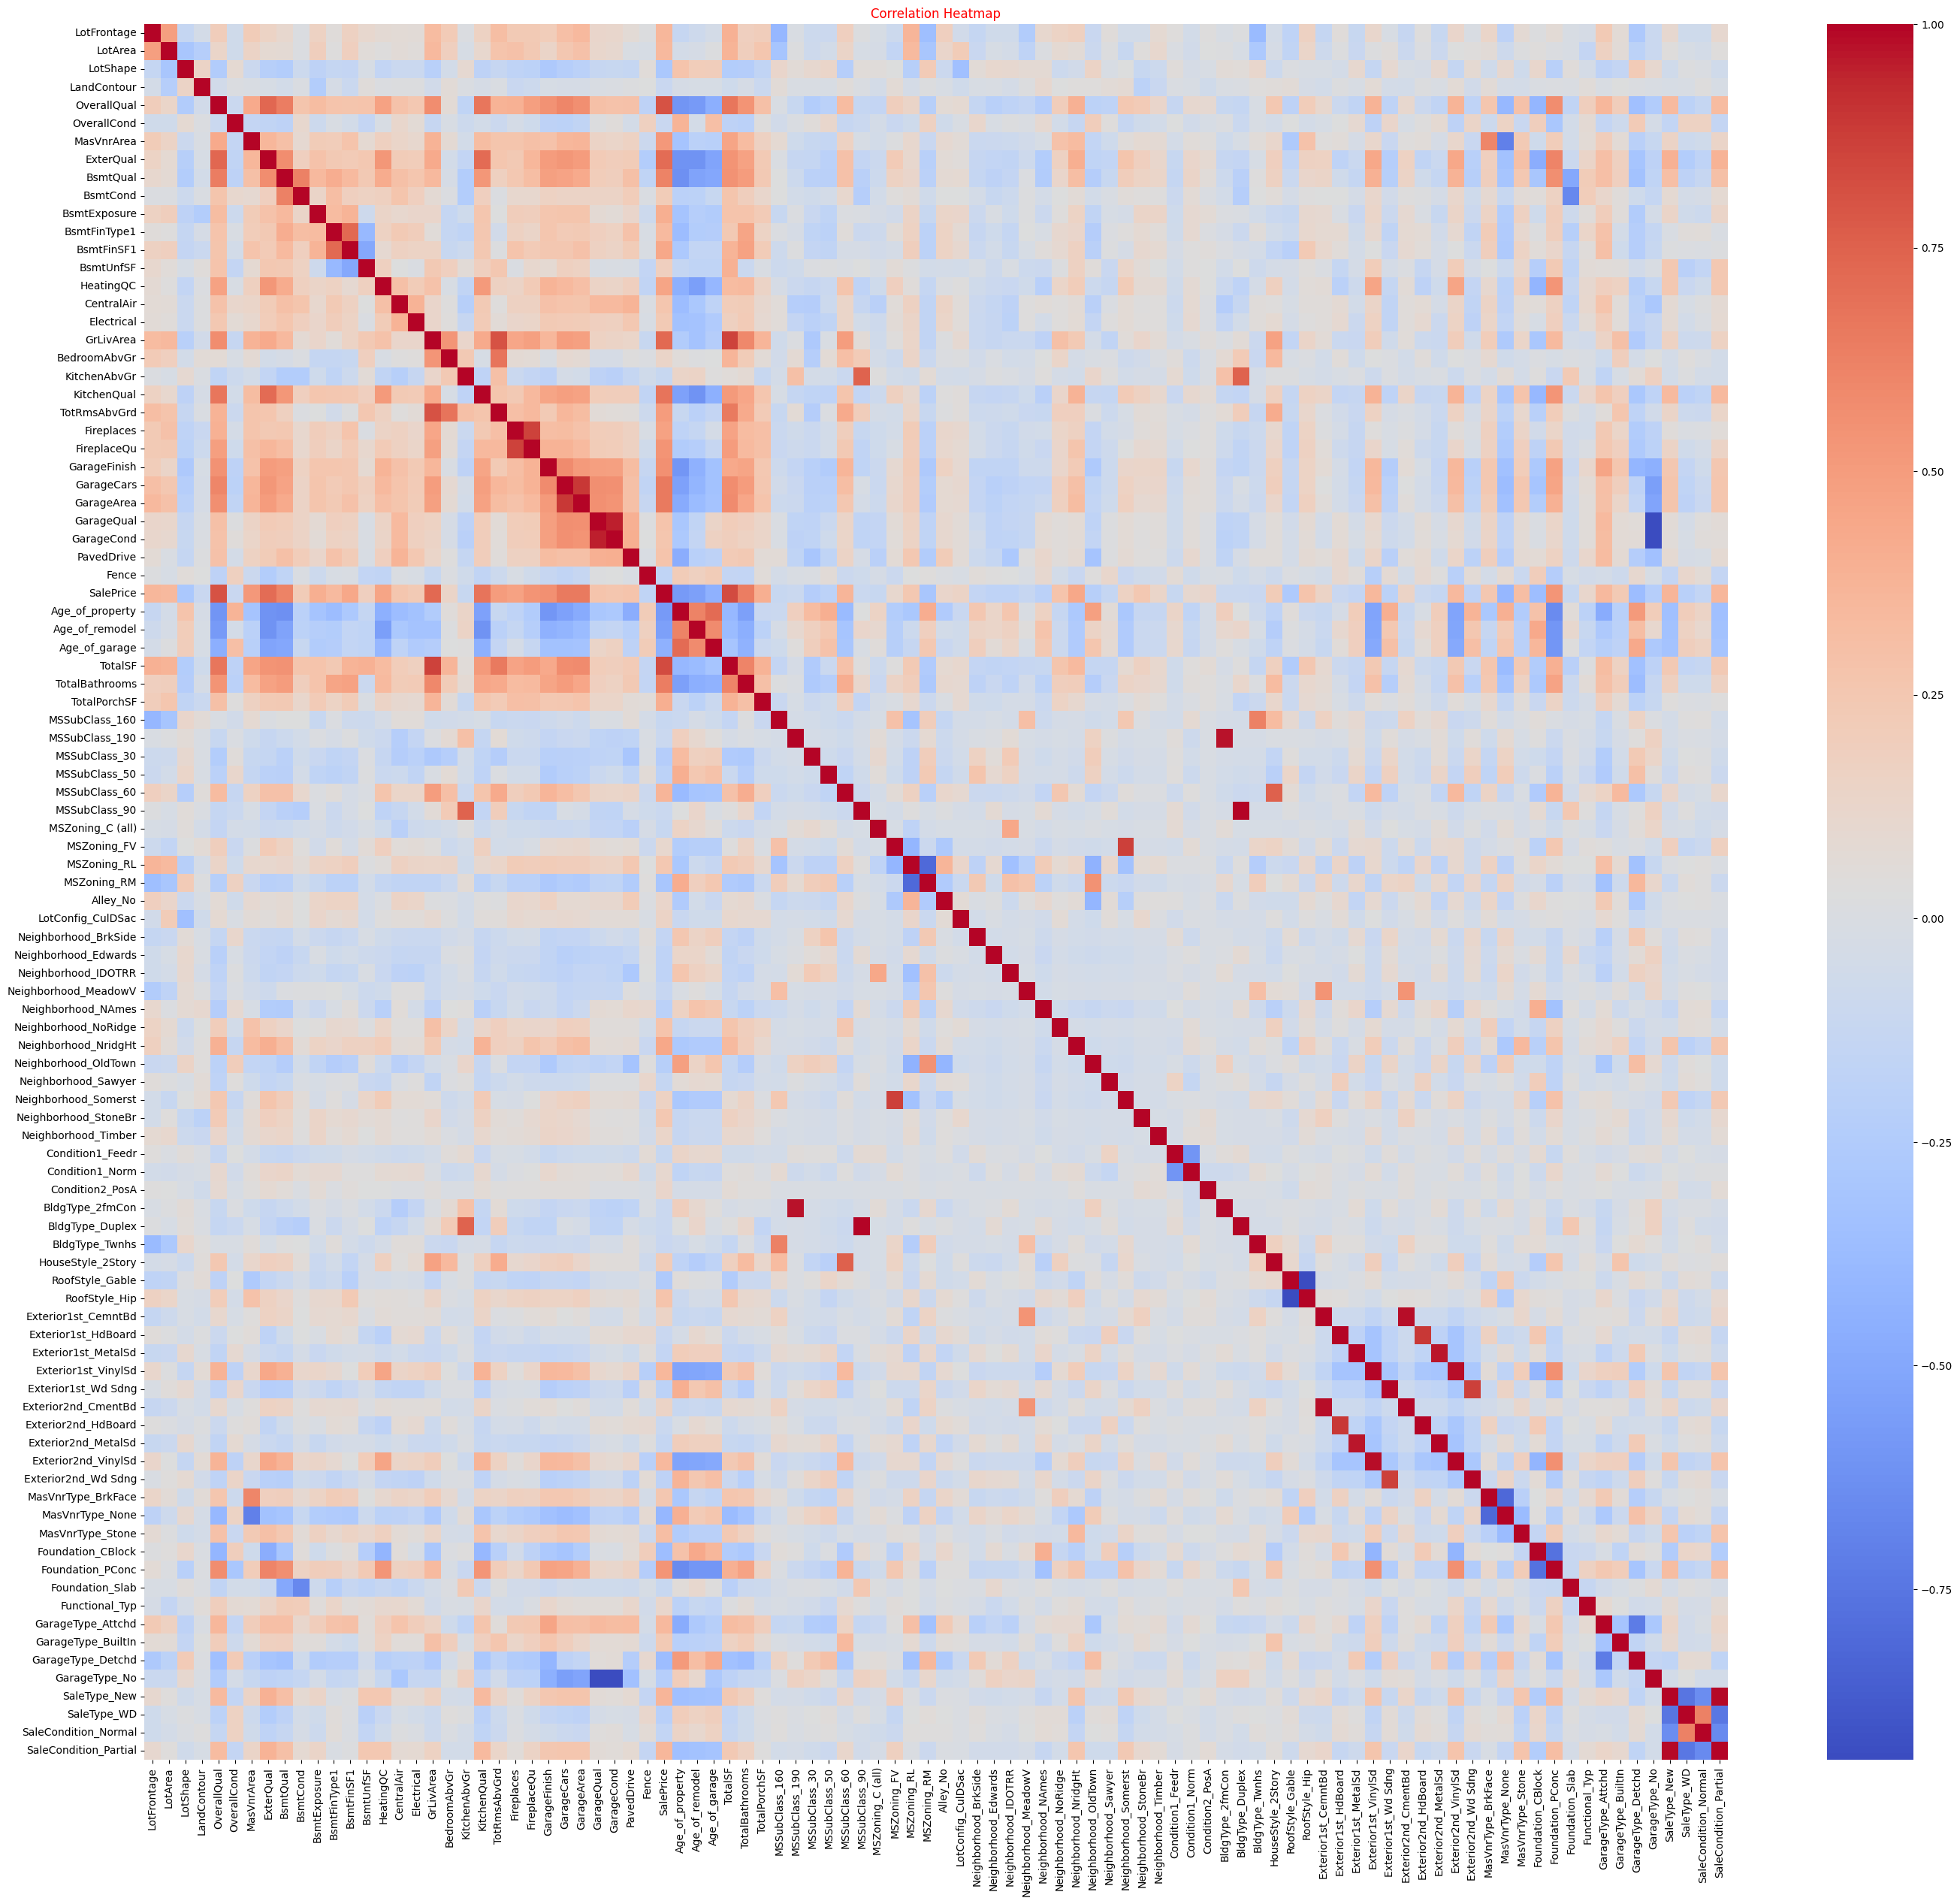

In [59]:
corr_train=df.corr()
low_corr_features = corr_train[(corr_train['SalePrice'] < 0.1) & (corr_train['SalePrice']> -0.1)].index
df_filtered = df.drop(columns=low_corr_features)

corr_train=df_filtered.corr()
print(corr_train['SalePrice'].sort_values(ascending = False))
plt.figure(figsize=(34, 30))

plt.title("Correlation Matrix",color="red",fontsize=15)
sns.heatmap(corr_train, annot=False, cmap='coolwarm', fmt ='.2f')
plt.title('Correlation Heatmap')
plt.show()

Some independent variables have high correlation with other features, which may cause issues. Therefore, we need to identify those with a correlation greater than 0.7 and retain only one of them.

In [60]:
corr_train=df_filtered.corr()
high_corr_pairs_with_values = []

# Identifying features with a correlation higher than 0.7
threshold = 0.7
for col in corr_train.columns:
    for row in corr_train.index:
        if col != row and abs(corr_train.loc[row, col]) > threshold:
            high_corr_pairs_with_values.append((row, col, corr_train.loc[row, col]))

# Displaying correlated features along with their correlation values
for feature1, feature2, corr_value in high_corr_pairs_with_values:
    print(f" {feature1} - {feature2}: {corr_value:.2f}")



 ExterQual - OverallQual: 0.73
 SalePrice - OverallQual: 0.81
 MasVnrType_None - MasVnrArea: -0.70
 OverallQual - ExterQual: 0.73
 KitchenQual - ExterQual: 0.72
 SalePrice - ExterQual: 0.71
 BsmtFinSF1 - BsmtFinType1: 0.72
 BsmtFinType1 - BsmtFinSF1: 0.72
 TotRmsAbvGrd - GrLivArea: 0.81
 SalePrice - GrLivArea: 0.72
 TotalSF - GrLivArea: 0.86
 MSSubClass_90 - KitchenAbvGr: 0.75
 BldgType_Duplex - KitchenAbvGr: 0.75
 ExterQual - KitchenQual: 0.72
 GrLivArea - TotRmsAbvGrd: 0.81
 FireplaceQu - Fireplaces: 0.86
 Fireplaces - FireplaceQu: 0.86
 GarageArea - GarageCars: 0.89
 GarageCars - GarageArea: 0.89
 GarageCond - GarageQual: 0.95
 GarageType_No - GarageQual: -0.93
 GarageQual - GarageCond: 0.95
 GarageType_No - GarageCond: -0.94
 OverallQual - SalePrice: 0.81
 ExterQual - SalePrice: 0.71
 GrLivArea - SalePrice: 0.72
 TotalSF - SalePrice: 0.83
 Age_of_garage - Age_of_property: 0.71
 Age_of_property - Age_of_garage: 0.71
 GrLivArea - TotalSF: 0.86
 SalePrice - TotalSF: 0.83
 BldgType_2fm

We identify features with a correlation above 0.7 and remove those that have less impact on the model's output

In [61]:
drop_items= ['ExterQual' , 'BsmtFinSF1' , 'GrLivArea' , 'Fireplaces' , 'GarageArea' , 'GarageCond' , 'Exterior1st_VinylSd'  , 'HouseStyle_2Story' ,
               'Exterior1st_VinylSd' , 'GarageType_No' , 'MSZoning_RL' , 'RoofStyle_Gable' , 'Foundation_CBlock' , 'GarageType_Attchd' , 'SaleType_WD' , 'SaleCondition_Partial'
                , 'BldgType_Duplex' , 'Exterior1st_Wd Sdng' , 'MasVnrType_BrkFace' , 'Exterior2nd_CmentBd' , 'Exterior2nd_MetalSd', 'MasVnrType_None' , 'MSSubClass_90' , 'Age_of_garage' ,
              'MSSubClass_190' , 'MSSubClass_90' , 'MSZoning_FV']
df_filtered.drop(drop_items , axis = 1 , inplace = True)


We will check whether our model experiences multicollinearity with these features.Features with a VIF value greater than 10 should be further examined, and if necessary, either they should be removed or another feature that is correlated with them should be deleted.

In [62]:
# Step 1: Add a constant (intercept) for the regression model
X = add_constant(df_filtered)

# Step 2: Create a DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns

# Step 3: Calculate VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF values
print(vif_data)

                 Feature         VIF
0                  const  514.057777
1            LotFrontage    2.008951
2                LotArea    1.949817
3               LotShape    1.393923
4            LandContour    1.256619
5            OverallQual    4.447724
6            OverallCond    1.950501
7             MasVnrArea    1.692738
8               BsmtQual    4.801195
9               BsmtCond    2.818374
10          BsmtExposure    1.567418
11          BsmtFinType1    2.407969
12             BsmtUnfSF    2.954054
13             HeatingQC    1.848238
14            CentralAir    1.629312
15            Electrical    1.334602
16          BedroomAbvGr    2.564619
17          KitchenAbvGr    1.811019
18           KitchenQual    2.504787
19          TotRmsAbvGrd    4.182594
20           FireplaceQu    1.678969
21          GarageFinish    2.512257
22            GarageCars    3.088717
23            GarageQual    2.357869
24            PavedDrive    1.711547
25                 Fence    1.156051
2

It is evident that the VIF values are within an acceptable range, and therefore, there is no multicollinearity issue.

In [63]:
# Separating the target from the features in order to continue the model-building process.
target = df_filtered['SalePrice']
features = df_filtered.drop('SalePrice' , axis =1)
feature_names = features.columns

In [64]:
# Standardizing the features using the StandardScaler method.
scaler = StandardScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(features) , columns = features.columns)

In [65]:
# Splitting the data into training and test sets.
x_train , x_test, y_train , y_test  = train_test_split(scaled_features , target ,test_size = 0.2, random_state = 42)

At this stage, a model will be created using XGBRegressor to identify the features with greater importance, which will be utilized in subsequent models.

                 Feature  Importance
4            OverallQual    0.501127
27               TotalSF    0.095789
21            GarageCars    0.044424
7               BsmtQual    0.040284
17           KitchenQual    0.034450
28        TotalBathrooms    0.022289
13            CentralAir    0.018038
35           MSZoning_RM    0.016307
23            PavedDrive    0.014421
19           FireplaceQu    0.012382
26        Age_of_remodel    0.011682
31         MSSubClass_30    0.011258
16          KitchenAbvGr    0.011114
67     GarageType_Detchd    0.010225
25       Age_of_property    0.009260
22            GarageQual    0.007086
9           BsmtExposure    0.006885
63      Foundation_PConc    0.006296
5            OverallCond    0.006144
33         MSSubClass_60    0.005890
10          BsmtFinType1    0.005476
30        MSSubClass_160    0.005143
62      MasVnrType_Stone    0.005035
65        Functional_Typ    0.004663
11             BsmtUnfSF    0.004417
69  SaleCondition_Normal    0.004372
1

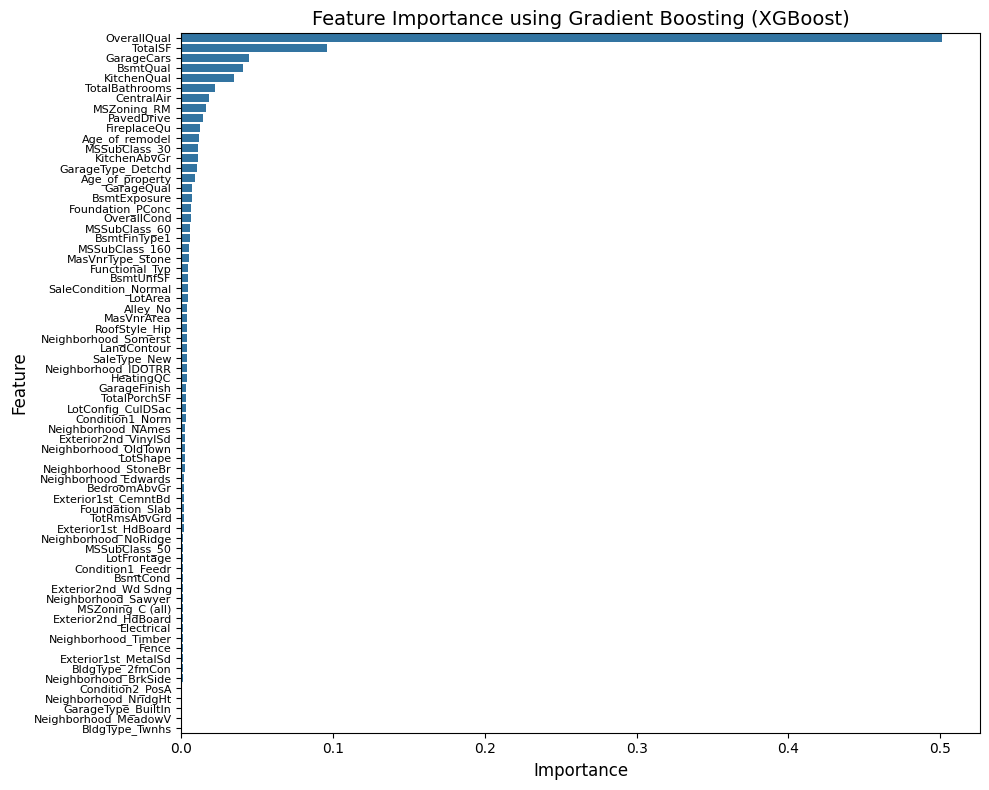

In [66]:
# Creating the Gradient Boosting model.

model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(x_train, y_train)

# Obtaining feature importance.
importance = model.feature_importances_

# Creating a DataFrame for features and their importance.
feature_importance_df = pd.DataFrame({
    'Feature': features.columns,
    'Importance': importance
})

# Sorting based on importance.
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

# Plotting the chart.
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature')
plt.title('Feature Importance using Gradient Boosting (XGBoost)', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.yticks(fontsize=8)
plt.xticks(fontsize=10)
plt.tight_layout()


plt.show()


At this stage, features with importance less than 0.002 will be removed from the model.

In [67]:
important_features = feature_importance_df[feature_importance_df['Importance'] >= 0.002]['Feature']


# Retaining only the important features in the DataFrame.
features = scaled_features[important_features]

x_train , x_test, y_train , y_test  = train_test_split(features, target ,test_size = 0.2, random_state = 42)

# Model Selection

In the following steps, we will train multiple models and select the two with the best performance.

In [68]:
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

In [69]:

# Initialize CatBoost Regressor
catboost_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, silent=True)

# Perform Cross-Validation for CatBoost (with 5-fold cross-validation)
catboost_cv_scores_mae = cross_val_score(catboost_model, x_train, y_train, cv=5, scoring=mae_scorer)

# Mean and Standard Deviation of Cross-Validation scores for CatBoost
catboost_mean_mae = -catboost_cv_scores_mae.mean()

# Print the results
print("\nCatBoost Regressor:")
print(f"Mean MAE: {catboost_mean_mae}")


CatBoost Regressor:
Mean MAE: 13105.246874047338


In [70]:
# Initialize XGBoost Regressor
xgboost_model = XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=6)

# Perform Cross-Validation for XGBoost (with 5-fold cross-validation)
xgboost_cv_scores_mae = cross_val_score(xgboost_model, x_train, y_train, cv=5, scoring=mae_scorer)

# Mean of Cross-Validation score for XGBoost
xgboost_mean_MAE = -xgboost_cv_scores_mae.mean()

# Print the results
print("\nXGBoost Regressor:")
print(f"Mean MAE : {xgboost_mean_MAE}")


XGBoost Regressor:
Mean MAE : 14161.993732497223


In [71]:
# Initialize Linear Regression
linear_model = LinearRegression()

# Perform Cross-Validation (with 5-fold cross-validation)
linear_cv_scores_mae = cross_val_score(linear_model, x_train, y_train, cv=5, scoring=mae_scorer)

# Mean of Cross-Validation score for Linear Regression
linear_mean_MAE = -linear_cv_scores_mae.mean()

# Print the results
print("\nlinear_model:")
print(f"Mean MAE : {linear_mean_MAE}")


linear_model:
Mean MAE : 17834.24344377206


In [72]:
# Initialize Ridge Regression
ridge_model = Ridge(alpha=1.0)

# Perform Cross-Validation (with 5-fold cross-validation)
ridge_cv_scores_mae = cross_val_score(ridge_model, x_train, y_train, cv=5, scoring=mae_scorer)


# Mean of Cross-Validation score for Ridge Regression
ridge_mean_MAE = -ridge_cv_scores_mae.mean()

# Print the results
print("\nridge_model:")
print(f"Mean MAE : {ridge_mean_MAE}")


ridge_model:
Mean MAE : 17830.67655605937


In [73]:
# Initialize Lasso Regression
lasso_model = Lasso(alpha=0.1)

# Perform Cross-Validation (with 5-fold cross-validation)
lasso_cv_scores_mae = cross_val_score(lasso_model, x_train, y_train, cv=5, scoring=mae_scorer)


# Mean of Cross-Validation score for Lasso Regression
lasso_mean_MAE = -lasso_cv_scores_mae.mean()

# Print the results
print("\nLasso Regression:")
print(f"Mean MAE : {lasso_mean_MAE}")


Lasso Regression:
Mean MAE : 17834.16380136588


In [74]:
# Initialize Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42)

# Perform Cross-Validation (with 5-fold cross-validation)
rf_cv_scores_mae = cross_val_score(rf_model, x_train, y_train, cv=5, scoring=mae_scorer)

# Mean of Cross-Validation scorefor Random Forest Regressor
rf_mean_MAE = -rf_cv_scores_mae.mean()

# Print the results
print("\nRandom Forest Regressor:")
print(f"Mean MAE : {rf_mean_MAE}")


Random Forest Regressor:
Mean MAE : 17206.925432960852


In [75]:
# Initialize Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)

# Perform Cross-Validation (with 5-fold cross-validation)
gb_cv_scores_mae = cross_val_score(gb_model, x_train, y_train, cv=5, scoring=mae_scorer)


# Mean of Cross-Validation score for Gradient Boosting Regressor
gb_mean_MAE = -gb_cv_scores_mae.mean()

# Print the results
print("\nGradient Boosting Regressor:")
print(f"Mean MAE : {gb_mean_MAE}")


Gradient Boosting Regressor:
Mean MAE : 13983.809682385112


It is clear that the CatBoost Regressor and Gradient Boosting Regressor models perform better than the others. Therefore, we will select these two models for the next steps.

# Hyperparameter Tuning

We optimize the hyperparameters of the two selected models.

In [76]:

# Initialize CatBoost Regressor
catboost_model = CatBoostRegressor(silent=True)

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'iterations': [500, 1000, 1500],  # Number of trees
    'learning_rate': [0.01, 0.05, 0.1],  # Step size
    'depth': [4, 6, 8],  # Tree depth
}

# fitting the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=catboost_model,
                                   param_distributions=param_dist,
                                   n_iter=30,
                                   scoring=mae_scorer,
                                   cv=5,
                                   verbose=1,
                                   random_state=42,
                                   n_jobs=-1)  # Use all available cores

random_search.fit(x_train, y_train)

# best parameters and best score
best_params = random_search.best_params_
best_score = -random_search.best_score_  # Convert back to positive MAE

# Print the results
print("\nBest Parameters from RandomizedSearchCV:")
print(best_params)
print(f"Best Mean Absolute Error: {best_score}")


Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best Parameters from RandomizedSearchCV:
{'learning_rate': 0.05, 'iterations': 1000, 'depth': 6}
Best Mean Absolute Error: 12879.706171899405


In [77]:
# We will recreate and fit the best model with its optimal parameters
cat_model = CatBoostRegressor(**best_params, silent=True)
cat_model.fit(x_train, y_train)

# Evaluating the model on the test data
y_test_pred = cat_model.predict(x_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the results
print(f"Mean Absolute Error on Test Data: {mae_test}")
print(f"R² Score on Test Data: {r2_test}")

Mean Absolute Error on Test Data: 13727.114955755516
R² Score on Test Data: 0.9348443257489678


In [78]:
# Initialize Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor()

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],  # Number of boosting stages
    'learning_rate': [0.01, 0.05, 0.1],  # Step size
    'max_depth': [3, 4, 5],  # Maximum depth of the individual estimators
    'subsample': [0.8, 1.0],  # Fraction of samples to use for fitting the individual base learners
    'min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2]  # Minimum number of samples required to be at a leaf node
}

# fitting the RandomizedSearchCV
random_search_gbr = RandomizedSearchCV(estimator=gbr_model,
                                       param_distributions=param_dist,
                                       n_iter=30,
                                       scoring=mae_scorer,
                                       cv=5,
                                       verbose=1,
                                       random_state=42,
                                       n_jobs=-1)

random_search_gbr.fit(x_train, y_train)

# best parameters and best score
best_params_gbr = random_search_gbr.best_params_
best_score_gbr = -random_search_gbr.best_score_  # Convert back to positive MAE

# Print the results
print("\nBest Parameters from RandomizedSearchCV for GradientBoostingRegressor:")
print(best_params_gbr)
print(f"Best Mean Absolute Error: {best_score_gbr}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best Parameters from RandomizedSearchCV for GradientBoostingRegressor:
{'subsample': 0.8, 'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 4, 'learning_rate': 0.1}
Best Mean Absolute Error: 13189.47273431635


In [79]:
# We will recreate the best model with its optimal parameters
gbr_model = GradientBoostingRegressor(**best_params_gbr, random_state = 46)

# Training the model with the training data
gbr_model.fit(x_train, y_train)

# Making predictions on the test data.
y_test_pred = gbr_model.predict(x_test)

# Calculating MAE and R² for the test data.
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the results
print(f"Mean Absolute Error on Test Data: {mae_test}")
print(f"R² Score on Test Data: {r2_test}")

Mean Absolute Error on Test Data: 14595.212308255695
R² Score on Test Data: 0.9292779129782622


# Ensemble Models

We use two ensemble methods to combine the models: voting and stacking, and then select the best model with the best performance. To evaluate and assess these models, we use three metrics: MAE, R², and RMSLE.

In [80]:
# Define RMSLE calculation function
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))

In [81]:
# Creating and fitting the VotingRegressor model
voting_model = VotingRegressor(estimators=[
    ('catboost', cat_model),
    ('gbr', gbr_model)
])

voting_model.fit(x_train, y_train)

# Evaluating the model
voting_predictions = voting_model.predict(x_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
rmsle_test = rmsle(y_test, voting_predictions)

# Printing the results
print(f"mae_score on Test Data: {mae_test}")
print(f"r2_score on Test Data: {r2_test}")
print(f"rmsle_score on Test Data: {rmsle_test}")

mae_score on Test Data: 14595.212308255695
r2_score on Test Data: 0.9292779129782622
rmsle_score on Test Data: 0.11498709744407382


In [82]:
# Creating and fitting the StackingRegressor model
meta_model = LinearRegression()

stacking_model = StackingRegressor(
    estimators=[
        ('catboost', cat_model),
        ('gbr', gbr_model)
    ],
    final_estimator=meta_model
)

stacking_model.fit(x_train, y_train)

# Evaluating the model

stacking_predictions = stacking_model.predict(x_test)
mae_stacking = mean_absolute_error(y_test, stacking_predictions)
r2_stacking = r2_score(y_test, stacking_predictions)
rmsle_stacking = np.sqrt(mean_squared_log_error(y_test, stacking_predictions))

# Printing the results
print(f"Stacking Mean Absolute Error (MAE): {mae_stacking}")
print(f"Stacking R² Score: {r2_stacking}")
print(f"Stacking RMSLE: {rmsle_stacking}")

Stacking Mean Absolute Error (MAE): 13722.717203734908
Stacking R² Score: 0.9364323542051872
Stacking RMSLE: 0.11506852771981


Based on the evaluation performed on both models, it is clear that the StackingRegressor model has better performance. Therefore, we select this model.

# Preparing Test Data

Before feeding the test data into the model, we need to prepare it in the same way as we did for the training data.

In [83]:
#We want the selected features from the test data to be the same as the features from the training data.
selected_feature_names = x_train.columns

In [84]:
df_test = transformer(df_test)


df_test['MSSubClass'] = df_test['MSSubClass'].apply(str)
nominal_features = ['MSSubClass' , 'MSZoning' , 'Street' , 'Alley' , 'Utilities' , 'LotConfig' , 'Neighborhood' , 'Condition1' , 'Condition2' , 'BldgType' , 'HouseStyle'
                    , 'RoofStyle' , 'RoofMatl' , 'Exterior1st', 'Exterior2nd' , 'MasVnrType' , 'Foundation' , 'Heating' , 'Functional' , 'GarageType' , 'MiscFeature'
                    ,'SaleType' ,  'SaleCondition']

df_test = pd.get_dummies(df_test, columns=nominal_features, drop_first = False)


bool_columns = df_test.select_dtypes(include=['bool']).columns

for col in bool_columns:
    df_test[col] = df_test[col].astype(int)

test_features = df_test[feature_names]

In [85]:
test_features.head()

,LotFrontage,LotArea,LotShape,LandContour,OverallQual,OverallCond,MasVnrArea,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtUnfSF,HeatingQC,CentralAir,Electrical,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,FireplaceQu,GarageFinish,GarageCars,GarageQual,PavedDrive,Fence,Age_of_property,Age_of_remodel,TotalSF,TotalBathrooms,TotalPorchSF,MSSubClass_160,MSSubClass_30,MSSubClass_50,MSSubClass_60,MSZoning_C (all),MSZoning_RM,Alley_No,LotConfig_CulDSac,Neighborhood_BrkSide,Neighborhood_Edwards,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_NAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Sawyer,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Condition1_Feedr,Condition1_Norm,Condition2_PosA,BldgType_2fmCon,BldgType_Twnhs,RoofStyle_Hip,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior2nd_HdBoard,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,MasVnrType_Stone,Foundation_PConc,Foundation_Slab,Functional_Typ,GarageType_BuiltIn,GarageType_Detchd,SaleType_New,SaleCondition_Normal
0,80.0,11622,3.0,3.0,5,6,0.0,3.0,3.0,0.0,3.0,270.0,2.0,1.0,4.0,2,1,2.0,5,0.0,1.0,1.0,3.0,2.0,3.0,594,594,1778.0,1.0,260,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
1,81.0,14267,2.0,3.0,6,6,108.0,3.0,3.0,0.0,5.0,406.0,2.0,1.0,4.0,3,1,3.0,6,0.0,1.0,1.0,3.0,2.0,0.0,630,630,2658.0,1.5,429,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1
2,74.0,13830,2.0,3.0,5,5,0.0,4.0,3.0,0.0,6.0,137.0,3.0,1.0,4.0,3,1,2.0,6,3.0,3.0,2.0,3.0,2.0,3.0,159,147,2557.0,2.5,246,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1
3,78.0,9978,2.0,3.0,6,6,20.0,3.0,3.0,0.0,6.0,324.0,4.0,1.0,4.0,3,1,3.0,7,4.0,3.0,2.0,3.0,2.0,0.0,150,150,2530.0,2.5,396,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1
4,43.0,5005,2.0,1.0,8,5,0.0,4.0,3.0,0.0,5.0,1017.0,4.0,1.0,4.0,2,1,3.0,5,0.0,2.0,2.0,3.0,2.0,0.0,217,217,2560.0,2.0,226,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1


In [86]:
scaled_test_features = pd.DataFrame(scaler.transform(test_features) , columns = test_features.columns)
selectes_test_features = scaled_test_features[selected_feature_names]

# prediction

We calculate the predicted values for the test data and save the results in the required format for the project

In [87]:
prediction = stacking_model.predict(selectes_test_features)

In [88]:
ids = range(1461, (1461 + len(prediction)))

#Creating the DataFrame
result_df = pd.DataFrame({
    'Id': ids,
    'SalePrice': prediction
})

# Saving the DataFrame as a CSV file
result_df.to_csv('predictions.csv', index=False)